In [35]:
import numpy as np
import deepdish as dd
import h5py

In [15]:
data = dd.io.load('clean_labeled_data.h5')

In [16]:
data.shape

(105, 840, 840)

## compute vector field for different mouse (i.e. key points)

In [457]:
def compute_vector_field(data, key_points):
    n_data = data.shape[0]
    n_row = data.shape[1]
    n_col = data.shape[2]
    
    one_row = np.arange(n_col)
    one_col = np.arange(n_row)
    
    vector_field = np.zeros(shape=(n_data, 16, n_row, n_col))
    print(vector_field.shape)
    
    for i in range(n_data):
        k = 0
        for j in range(len(key_points)):
            coordinate = np.where(data[i] == key_points[j])
            dx_row = (coordinate[0] - one_row).reshape(1, -1)
            dx_col = (coordinate[1] - one_col).reshape(-1, 1)
            dx = dx_row.repeat(n_row, axis=0)
            vector_field[i,k] = dx
            k += 1
            dy = dx_col.repeat(n_col, axis=1)
            vector_field[i,k] = dy
            k += 1
    return vector_field
    
    """
    # one possible strategy
    file_name = 'vector_field.h5'
    dd.io.save(file_name, vector_field)    
    """
    

    """
    # another possible strategy
    print("loop finished!")
    print("begin to convert list to numpy array...")
    print("convert successfully!")
    print("begin to save file...")
    file_name = 'vector_field.h5'
    h5f = h5py.File(file_name, 'w')
    h5f.create_dataset('vector_field_dataset', data=vector_field)
    h5f.close()
    print("save file successfully!!!")    
    """


In [276]:
n_mice = 4
n_key_points = 2 # number of key points for each mouse
key_points = np.arange(n_key_points * n_mice) + 1

In [209]:
key_points

array([1, 2, 3, 4, 5, 6, 7, 8])

In [210]:
vector_field = compute_vector_field(data, key_points)

(3, 16, 840, 840)


vector_field.shape = (n_data, n_distance, n_rows, n_cols)
<br>
16 = (dxh+dyh+dxt+dyt)*four_mice

In [211]:
vector_field.shape

(3, 16, 840, 840)

In [212]:
print(vector_field[0].shape)

(16, 840, 840)


## compute Euclidean distances

In [224]:
square_distances = vector_field**2

compute euclidean distance

In [253]:
def compute_euclidean(square_distances, n_key_points, n_mice):
    n_data = square_distances.shape[0]
    n_maps = square_distances.shape[1]
    n_rows = square_distances.shape[2]
    n_cols = square_distances.shape[3]

    euclidean_distances = np.zeros(shape=(n_data, n_key_points * n_mice, n_rows, n_cols))
    for i in range(n_data):
        k = 0
        for j in range(n_maps // 2):
            # add x_distance with y_distance in order to get euclidean distance for each mouse
            euclidean_distances[i, j] = square_distances[i, k] + square_distances[i, k+1]
            k += 2
    return euclidean_distances

In [254]:
euclidean_distances = compute_euclidean(square_distances, n_key_points, n_mice)

8 of euclidean_distances.shape = (euclidean_head+euclidean_tail)*n_mice

In [256]:
euclidean_distances.shape

(3, 8, 840, 840)

add head and tail euclidean distance for all pixels

In [328]:
def compute_total_distance(euclidean_distances, n_mice):
    n_data = square_distances.shape[0]
    n_rows = square_distances.shape[2]
    n_cols = square_distances.shape[3]
    total_distance = np.zeros(shape=(n_data, n_mice, n_rows, n_cols))
    
    for i in range(n_data):
        k = 0
        for j in range(n_mice):
            total_distance[i, j] = euclidean_distances[i, k] + euclidean_distances[i, k+1]
            k += 2
    return total_distance

In [329]:
total_distance = compute_total_distance(euclidean_distances, n_mice)

total_distance.shape = (n_data, n_mice, n_rows, n_columns)

In [330]:
total_distance.shape

(3, 4, 840, 840)

find the minimum total distance (i.e. to head distance and to tail distance) from four mice

In [398]:
def find_min_dist(total_distance):
    n_data = total_distance.shape[0]
    n_rows = square_distances.shape[2]
    n_cols = square_distances.shape[3]    
    min_distances = np.zeros(shape=(n_data, n_rows, n_cols))
    
    for i in range(n_data):
        min_distances[i] = total_distance[i].T.min(2)
    return min_distances

In [400]:
min_distances = find_min_dist(total_distance)

In [405]:
min_distances[0]

array([[ 845178.,  843938.,  842702., ...,  963195.,  964039.,  964887.],
       [ 842902.,  841662.,  840426., ...,  960557.,  961401.,  962249.],
       [ 840630.,  839390.,  838154., ...,  957923.,  958767.,  959615.],
       ..., 
       [ 339630.,  338390.,  337154., ...,  154653.,  155497.,  156345.],
       [ 340702.,  339462.,  338226., ...,  155363.,  156207.,  157055.],
       [ 341778.,  340538.,  339302., ...,  156077.,  156921.,  157769.]])

find argmin, namely belonging mice, w.r.t. minimum of total distance to head and tail

In [391]:
def choose_mouse(total_distance):
    n_data = total_distance.shape[0]
    n_rows = square_distances.shape[2]
    n_cols = square_distances.shape[3]    
    belong_mice = np.zeros(shape=(n_data, n_rows, n_cols))
    
    for i in range(n_data):
        belong_mice[i] = total_distance[i].T.argmin(2)
    return belong_mice

Note: [0,1,2,3] in belonging mice corresponding to mice[1,2,3,4] in the vector field

In [392]:
belong_mice = choose_mouse(total_distance)

belong_mice.shape = (n_data, n_rows, n_columns)

In [541]:
belong_mice.shape

(3, 840, 840)

compute vector fields with minimum euclidean distance w.r.t. head and tile

In [561]:
def min_vector_field(vector_field, belong_mice, n_mice):
    n_data = vector_field.shape[0]
    n_rows = vector_field.shape[2]
    n_cols = vector_field.shape[3]
    n_maps = 4 # contains dxh,dyh,dxt,dyt
    min_vec_fields = np.zeros(shape=(n_data, n_maps, n_rows, n_cols))
    
    k = 0 # minimum vector filed index for [dxh,dyh,dxt,dyt]
    for i in range(n_data):
        for j in range(n_mice):
            coordinates = np.where(belong_mice[i] == j)
            min_vec_fields[i][k][coordinates] = vector_field[i][4*j][coordinates].copy()
            min_vec_fields[i][k+1][coordinates] = vector_field[i][4*j+1][coordinates].copy()
            min_vec_fields[i][k+2][coordinates] = vector_field[i][4*j+2][coordinates].copy()
            min_vec_fields[i][k+3][coordinates] = vector_field[i][4*j+3][coordinates].copy()
    return min_vec_fields

In [562]:
min_vec_fields = min_vector_field(vector_field, belong_mice, n_mice)

min_vec_fields.shape = (n_data, n_maps, n_rows, n_columns)
<br>
Note: n_maps = [dxh, dyh, dxt, dyt]

In [563]:
min_vec_fields.shape

(3, 4, 840, 840)

## save minimum vector fields

In [ ]:
file_name = 'vector_fields.h5'
dd.io.save(file_name, min_vec_fields)

In [564]:
import matplotlib.pyplot as plt

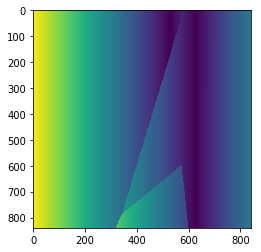

In [577]:
plt.imshow(np.abs(min_vec_fields[0][0]))
plt.show()

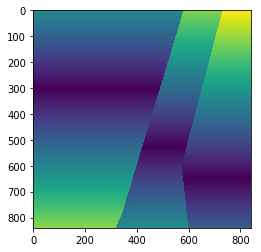

In [576]:
plt.imshow(np.abs(min_vec_fields[0][1]))
plt.show()

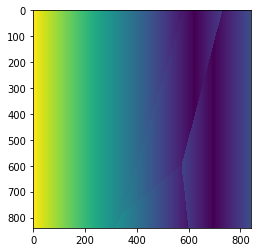

In [575]:
plt.imshow(np.abs(min_vec_fields[0][2]))
plt.show()

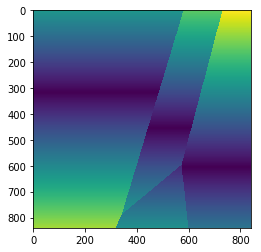

In [574]:
plt.imshow(np.abs(min_vec_fields[0][3]))
plt.show()